In [1]:
import multiprocessing
import time
import os
import random
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import datetime
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

import kaleido
import pandas as pd
import numpy as np

from copy import deepcopy
from scipy.linalg import pinv
import random
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from joblib import Parallel, delayed

In [2]:
from features.feature_module import *

In [3]:
fsize = 15
tsize = 16
tdir = 'in'
major = 9.0
minor = 5.0
lwidth = 0.8
lhandle = 2.0
plt.style.use('default')
#plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 300  # for preview, doesn't affect savefig
plt.rcParams['savefig.dpi'] = 800
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = 2

In [4]:
random.seed(12)

In [53]:
df_ohlc = pd.read_excel('GBPUSD_1h.xlsx')

In [54]:
df_ohlc.drop(columns='Unnamed: 0', inplace=True)
df_ohlc.set_index('Datetime', inplace=True)
df_ohlc.index = pd.to_datetime(df_ohlc.index, utc = True)
df_ohlc.index = df_ohlc.index.tz_convert('UTC')

In [55]:
def get_all_features(df_ohlc):
    list_of_windows = [63, 126]
    momentum_periods = [2, 4, 8, 16, 32]
    quantiles = [0.01, 0.05, 0.95, 0.99]
    predict_periods = [1, 2, 4, 6]
    offsets = [1, 2, 4, 6]

    frame = Features(df=df_ohlc,
                     list_of_windows=list_of_windows,
                     momentum_periods=momentum_periods,
                     quantiles=quantiles,
                     predict_periods=predict_periods,
                     offsets=offsets).get_features()
    
    frame.replace([np.inf, -np.inf], np.nan, inplace=True)
    frame.fillna(method='ffill',inplace = True)
    frame.dropna(inplace=True)
    
    return frame

In [56]:
df = get_all_features(df_ohlc)

In [57]:
df

,open,high,low,close,spread_close,spread_open,spread_high,spread_low,sma_w_63,diff_close_sma_w_63,...,trend_ret_4_pred_deg_3_win_126,trend_ret_4_pred_deg_4_win_126,trend_ret_4_pred_deg_5_win_126,trend_ret_4_pred_deg_6_win_126,trend_ret_6_pred_deg_1_win_126,trend_ret_6_pred_deg_2_win_126,trend_ret_6_pred_deg_3_win_126,trend_ret_6_pred_deg_4_win_126,trend_ret_6_pred_deg_5_win_126,trend_ret_6_pred_deg_6_win_126
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-29 17:00:00+00:00,1.347345,1.349090,1.346900,1.348255,0.00005,0.00001,0.00004,0.00004,1.343305,0.003685,...,-0.001229,-0.002591,-0.000025,0.006491,-0.001540,-0.003144,-0.000932,-0.002652,0.000873,0.010623
2021-12-29 18:00:00+00:00,1.348255,1.348940,1.348175,1.348940,0.00008,0.00005,0.00008,0.00005,1.343423,0.004106,...,-0.001353,-0.002263,0.000584,0.007410,-0.001992,-0.003258,-0.001028,-0.002176,0.001733,0.011947
2021-12-29 19:00:00+00:00,1.348940,1.349040,1.348365,1.348960,0.00004,0.00008,0.00006,0.00005,1.343552,0.004025,...,-0.000956,-0.001615,0.001626,0.008223,-0.001926,-0.002937,-0.000595,-0.001427,0.003025,0.012896
2021-12-29 20:00:00+00:00,1.348960,1.348985,1.348335,1.348440,0.00002,0.00004,0.00006,0.00004,1.343682,0.003541,...,-0.000272,-0.000710,0.002675,0.008909,-0.001481,-0.002246,0.000110,-0.000443,0.004207,0.013535
2021-12-29 21:00:00+00:00,1.348440,1.349040,1.348130,1.348985,0.00045,0.00002,0.00021,0.00004,1.343825,0.003840,...,-0.000301,-0.000624,0.003068,0.008634,-0.001792,-0.002354,0.000114,-0.000294,0.004777,0.013105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13 10:00:00+00:00,1.252620,1.252950,1.250950,1.251630,0.00004,0.00002,0.00004,0.00004,1.255553,-0.003124,...,0.001882,0.001249,-0.003120,-0.000703,0.002304,0.002813,0.001720,0.000920,-0.005081,-0.001465
2023-12-13 11:00:00+00:00,1.251630,1.252860,1.251345,1.252780,0.00004,0.00004,0.00001,0.00001,1.255521,-0.002183,...,0.000760,-0.000144,-0.004333,-0.001412,0.001349,0.001671,0.000584,-0.000557,-0.006311,-0.001942
2023-12-13 12:00:00+00:00,1.252780,1.253075,1.251585,1.251815,0.00005,0.00004,0.00001,0.00002,1.255472,-0.002913,...,0.001190,0.000063,-0.004161,-0.000644,0.002044,0.002196,0.000982,-0.000442,-0.006244,-0.000982


In [89]:
## Initial dataframe is divided into past and future in order to prevent look ahead basis

df_past = df[:7000] ## arbitrary division 
df_future = df[700:]

In [59]:
## generates features ##

class GaussianRFF():

    def __init__(self,d,D,kernel_var=1, seed=True):
        if seed == True:
            np.random.seed(0)
        self.A = np.random.normal(loc=0,scale=kernel_var,size=(d,D)) #normal between 0 and 1
        self.b = np.random.uniform(low=0,high=2*np.pi,size=(D,1)) #uniform between 0 and 2pi
        self.D = D

    def transform(self, x):
        """
        x - feature vector (d x 1)
        z - rff feature vector (D x 1)
        """
        temp = (self.A.T @ x + self.b)
        z = np.sqrt(2/self.D) * np.cos(temp)
        return z

In [60]:
## Givens Rotation ##

def Givens_Rotation(R):
    n = len(R)
    Q = np.identity(n)
    for j in range(R.shape[1]):
        for i in range(j+1,n):
            x=R[j][j]
            y=R[i][j]
            r=np.sqrt(x**2+y**2)
            if r!=0:
              c = x/r
              s = -y/r
              I = np.identity(n)
              I[i,i] = c
              I[j,j] = c
              I[i,j] = s
              I[j,i] = -s
              Q = Q@I.T
              R = I@R
    
    #return R[:n,:]
    return Q,R

In [61]:
# last row givens #

def givens(self, update=True):

    # this section is run if we are updating
    if update:
        A = self.A
        if A.shape[0] > A.shape[1]:
            diag = A.shape[1]-1

        else:
            diag = A.shape[0]-1

        G = np.identity(A.shape[0])
        all_Q = deepcopy(self.all_Q)
        all_Q = np.concatenate((all_Q,np.zeros((all_Q.shape[0],1))),axis=1)
        all_Q = np.concatenate((all_Q,np.zeros((1,all_Q.shape[1]))),axis=0)
        all_Q[-1,-1] = 1
        Q = deepcopy(G)

        for i in range(diag):
            x = A[i,i]
            y = A[-1,i]
            r = np.sqrt(x**2 + y**2)
            c = x / r
            s = -y / r
            G[i,i] = c
            G[-1,-1] = c
            G[i,-1] = -s
            G[-1,i] = s
            A = G @ A
            Q = Q @ G.T
            G = np.identity(A.shape[0])

        self.all_Q = all_Q @ Q
        return Q.T,A

    # this section is run if we are deleting
    else:

        P = self.P
        G = np.identity(P.shape[1])
        G_all = deepcopy(G)
        diag = P.shape[1]-1
        A = self.A
        q = self.all_Q[0,:].reshape(self.all_Q.shape[1],1)

        for i in range(diag,0,-1):
            x = q[0,0]
            y = q[i,0]
            r = np.sqrt(x**2 + y**2)
            c = x / r
            s = -y / r
            G[i,i] = c
            G[0,0] = c
            G[0,i] = -s
            G[i,0] = s
            A = G @ A
            G_all = G_all @ G.T
            q = G @ q
            G = np.identity(self.all_Q.shape[0])

        self.all_Q = self.all_Q @ G_all

        return G_all

     

In [62]:
class QrRlS:

    def __init__(self,x,y,max_obs,ff, l):

        """
        x - Initial input Dataset
        y - Initial output Dataset
        max_obs = Rolling window size
        ff = Forgetting factor
        l = lambda(regularization term)
        """

        self.X = x
        self.y = y
        self.dim = len(x)
        self.I = np.eye(self.dim)
        ff = np.sqrt(ff)
        self.ff = ff
        self.l = l
        self.b = 1
        
        # Forgetting factor matrix
        B = np.diag([ff**i for i in range(x.shape[1]-1,-1,-1)])
        self.X = self.X @ B
        self.n_batch = x.shape[1]
        self.Q, self.R = Givens_Rotation(self.X.T)
        self.R_inv = pinv(self.R)
        self.w = self.R_inv @ self.Q.T @ y
        self.z = self.Q.T @ y

        # A and P were used as R and R inverse
        self.A = self.R
        self.P = self.R_inv
        self.max_obs = max_obs
        self.all_Q = deepcopy(self.Q)
        self.i = 1
        
    def update(self,x,y):

        self.X = np.c_[self.X, x]
        self.y = np.r_[self.y,y]
        nobs = np.shape(self.X)[1]
        self.P = (1/self.ff)*self.P
        self.A = self.ff * self.A
        d = x.T @ self.P
        c = x.T @ (np.eye(self.A.shape[1]) - self.P @ self.A)

        # Update for new regime
        if not np.allclose(0,c):
            c_inv = pinv(c)
            self.P = np.c_[self.P - c_inv @ d, c_inv]

        # Update for old regime
        else:
            b_k = 1/(1 + d @ d.T) * self.P @ d.T
            self.P = np.c_[self.P - b_k @ d, b_k]

        self.A = np.r_[self.A, x.T]
        self.Q,self.A = givens(self)
        y = np.array(self.y).reshape(self.X.shape[1],1)
        self.w = self.P @ y
        self.P = self.P @ self.Q.T
        self.i += 1
        
        if nobs > self.max_obs:
            x = self.X[:,0].reshape(self.dim, 1)
            self.delete(x, self.y[0])


    def delete(self,x,y):

        """
        x - features which will get deleted (dim x 1)
        y - target which will get deleted (scalar)
        """

        temp = np.allclose(np.eye(self.A.shape[1]), self.A.T @ self.P.T)
        self.X = self.X[:, 1:]
        self.Q = givens(self, False)
        self.P = self.P @ self.Q
        self.A = self.Q.T @ self.A
        x = self.A[0,:].reshape(self.dim, 1)
        c = np.zeros((self.P.shape[1], 1))
        c[0, 0] = 1
        k = self.P @ c
        h = x.T @ self.P
        je = x.T @ self.P @ c

        # Deletion for new regime
        if not temp:
            self.P = self.P - k @ pinv(k) @ self.P - self.P @ pinv(h) @ h + (pinv(k) @ self.P @ pinv(h)) * k @ h
            # this line causing issues in the QrRLS bagging - k or h are inf

        # Deletion for old regime
        else:
            x = -x
            h = x.T @ self.P
            u = (np.eye(self.P.shape[1]) - self.A @ self.P) @ c
            k = self.P @ c
            h_mag = h @ h.T
            u_mag = u.T @ u
            S = (1 + x.T @ self.P @ c)
            p_2 = - ((u_mag)/S * self.P @ h.T) - k
            q_2 = - ((h_mag)/S * u.T - h)
            sigma_2 = h_mag * u_mag + S**2
            self.P = self.P + 1/S * self.P @ h.T @ u.T - S/sigma_2 * p_2 @ q_2
        
        self.P = self.P[:,1:]
        self.A = self.A[1:,:]
        y = np.array(self.y).reshape(self.X.shape[1]+1,1)
        y = self.all_Q.T @ y
        y = y[1:]
        self.w = self.P @ y
        self.all_Q = self.all_Q[1:,1:]
        self.y = self.y[1:]


    def pred(self,x):
        """
        x - features (dim x 1)
        """
        
        if x.shape[1] == 1:
            pred = (x.T @ self.w).item()
            
        else:
            pred = x.T @ self.w
        return pred

    

In [63]:
def prepare_data_new(df):
    
    """
    Performs scaling and calculates targets for training from initial dataframe
    Args:
    df (Pandas dataframe): Initial dataframe of size rolling_window + 1


    Returns:
    scaled_target_var (np.array): scaled target variable 
    feature_df (np.array): scaled feature matrix
    scaler_target,scaler_feature: scalers for target variable and feature matrix respectively 
    """
    scaler_target = StandardScaler()
    scaler_feature = StandardScaler()
    
    #df = get_all_features(df_past)
    #df = df[-(roll_size+1):]
    target_var = df['close'].shift(-1) / df['close'] -1
    target_var.dropna(inplace=True)
    target_var = pd.DataFrame(target_var)
    scaled_target_var = scaler_target.fit_transform(target_var)
    
    feature_matrix = df.drop(columns = ["close"])
    feature_df = scaler_feature.fit_transform(feature_matrix)

    scaled_target_var = scaled_target_var.T
    feature_df = feature_df.T
    
    #return target_var, df
    return scaled_target_var,feature_df,scaler_target,scaler_feature;

In [96]:
def sample_features(D, n_bags, feat_num):
    """
    Randomly samples the feature space and allocates features per bag. Samples with replacement if the total 
    feature space is smaller than n_bags*feat_num, otherwise without replacement.

    Args:
    features_array (np.array): Array of features.
    n_bags (int): Number of bags.
    feat_num (int): Number of features in each bag.

    Returns:
    list: A list of arrays, where each array contains the indices of the features in each bag.
    """
    total_features = D

    # Determine if sampling should be with or without replacement
    replace = total_features < n_bags * feat_num

    # Initialize an empty list to store the feature indices for each bag
    features_array = []

    # Randomly sample feature indices for each bag
    for _ in range(n_bags):
        bag_indices = np.random.choice(total_features, size=feat_num, replace=replace)
        features_array.append(bag_indices)

    return features_array

In [139]:

# Define the function that will process each bag in the first loop
def process_initial_bag(p, bags, Y, scaler_Y, ff, l, feature_num, roll_size):
    
    #initialize and train models
    mod_QRRLS = QrRlS(bags[p].T[:, :roll_size], Y.T[:roll_size], roll_size, ff, l)
    
    #make prediction
    pred_QRRLS = scaler_Y.inverse_transform(np.array(mod_QRRLS.pred(bags[p][roll_size].reshape(feature_num, 1))).reshape(-1,1))
    return pred_QRRLS, mod_QRRLS

# Define the function that will process each bag in the second loop
def process_updated_bag(p, X_trans, X_new, models, scaler_Y, Y, features_array, feature_num):
    
    u = X_trans[features_array[p]].reshape(feature_num, 1) #record features for update training 
    d = Y.T[-1].reshape(-1, 1) #record targets for update training
    
    #update models
    models[p].update(u, d)
    
    #make prediction 
    pred_QRRLS = scaler_Y.inverse_transform(np.array(models[p].pred(X_new[features_array[p]].reshape(feature_num, 1))).reshape(-1,1))
    
    return pred_QRRLS


In [172]:
D = 600
sigma = 1
ff = 1
l = 0
roll_size = 400
n_bags = 1
feature_num = D 
overlap = False

#initialize dataframe for results recording
last_index_df_past = df_past.index[-1:]
indices_df_future = df_future.index[:-1]
combined_indices = last_index_df_past.append(indices_df_future)
results_df = pd.DataFrame(index=combined_indices)
results_df['actual'] = np.nan
results_df['mean'] = np.nan

In [173]:
# Initialize the neccesary lists
models = []
bags = []

# Select the most recent data from the available dataframe
df_model = df_past[-(roll_size+1):] # size is roll_size + 1, because we need 1 more point to make prediction
                                    # for that point we don't know the target variable yet

# calculate targets and scale the data
Y, X, scaler_Y, scaler_X = prepare_data_new(df_model) 

# perform RFF transformation
lags = X.shape[0]
rff = GaussianRFF(lags, D, sigma)
X_trans = rff.transform(X.reshape(lags, roll_size+1)).T

#Sampling features in each bag
features_array = sample_features(D,n_bags,feature_num)

for p in range(n_bags):
    bags.append(X_trans[:,features_array[p]])

# Parallel execution of the first loop. Model initialization
results = Parallel(n_jobs=-1)(delayed(process_initial_bag)(p, bags, Y, scaler_Y, ff, l, feature_num, roll_size) for p in tqdm(range(0, n_bags)))
all_bags_preds = np.array([result[0] for result in results])
models = [result[1] for result in results]

#Add results in a results dataframe for comparison
results_df['actual'].iloc[0] = df_future['close'][0]/df_past['close'][-1]-1 #actual target
results_df['mean'].iloc[0] = np.mean(all_bags_preds)

#Continue performing forecasts by updating QR_RLS model
df_temp = df_model

# we need the last row of RFF dataset to append it to train set on next iteration
X_old = X_trans[-1,:].T  

for i in tqdm(range(0, 300)):
    
    #Delete old data and append data, that just became available
    df_temp = df_temp.iloc[1:]
    df_temp = df_temp.append(df_future.iloc[i])
    
    Y, X, scaler_Y, scaler_X = prepare_data_new(df_temp)
    
    ## We need to perform RFF expansion on the new observation row. For which we don't have target
    ## And which will be used for forecasting
    X_new = rff.transform(X[:, -1:].reshape(lags, 1))
    
    # Parallel execution of the second loop
    all_bags_preds = Parallel(n_jobs=-1)(delayed(process_updated_bag)(p, X_old, X_new, models, scaler_Y, Y, features_array, feature_num) for p in range(0, n_bags))
    
    #new obeservation will be appended to train set in the next iteration
    X_old = X_new 
    
    # record results
    results_df['actual'].iloc[i+1] = df_future['close'][i+1]/df_temp['close'][-1]-1 #actual target
    results_df['mean'].iloc[i+1] = np.mean(all_bags_preds)


100%|█████████████████████████████████████████| 300/300 [37:11<00:00,  7.44s/it]


In [174]:
results_df.dropna(inplace=True)

In [175]:
same_sign_count = ((results_df['mean'] > 0) & (results_df['actual'] > 0)).sum() + ((results_df['mean'] < 0) & (results_df['actual'] < 0)).sum()

# Calculate the percentage
total_rows = len(results_df)
percentage_same_sign = (same_sign_count / total_rows) * 100

print(f"Count of rows with columns of the same sign: {same_sign_count}")
print(f"Percentage of total: {percentage_same_sign:.2f}%")

Count of rows with columns of the same sign: 170
Percentage of total: 56.48%


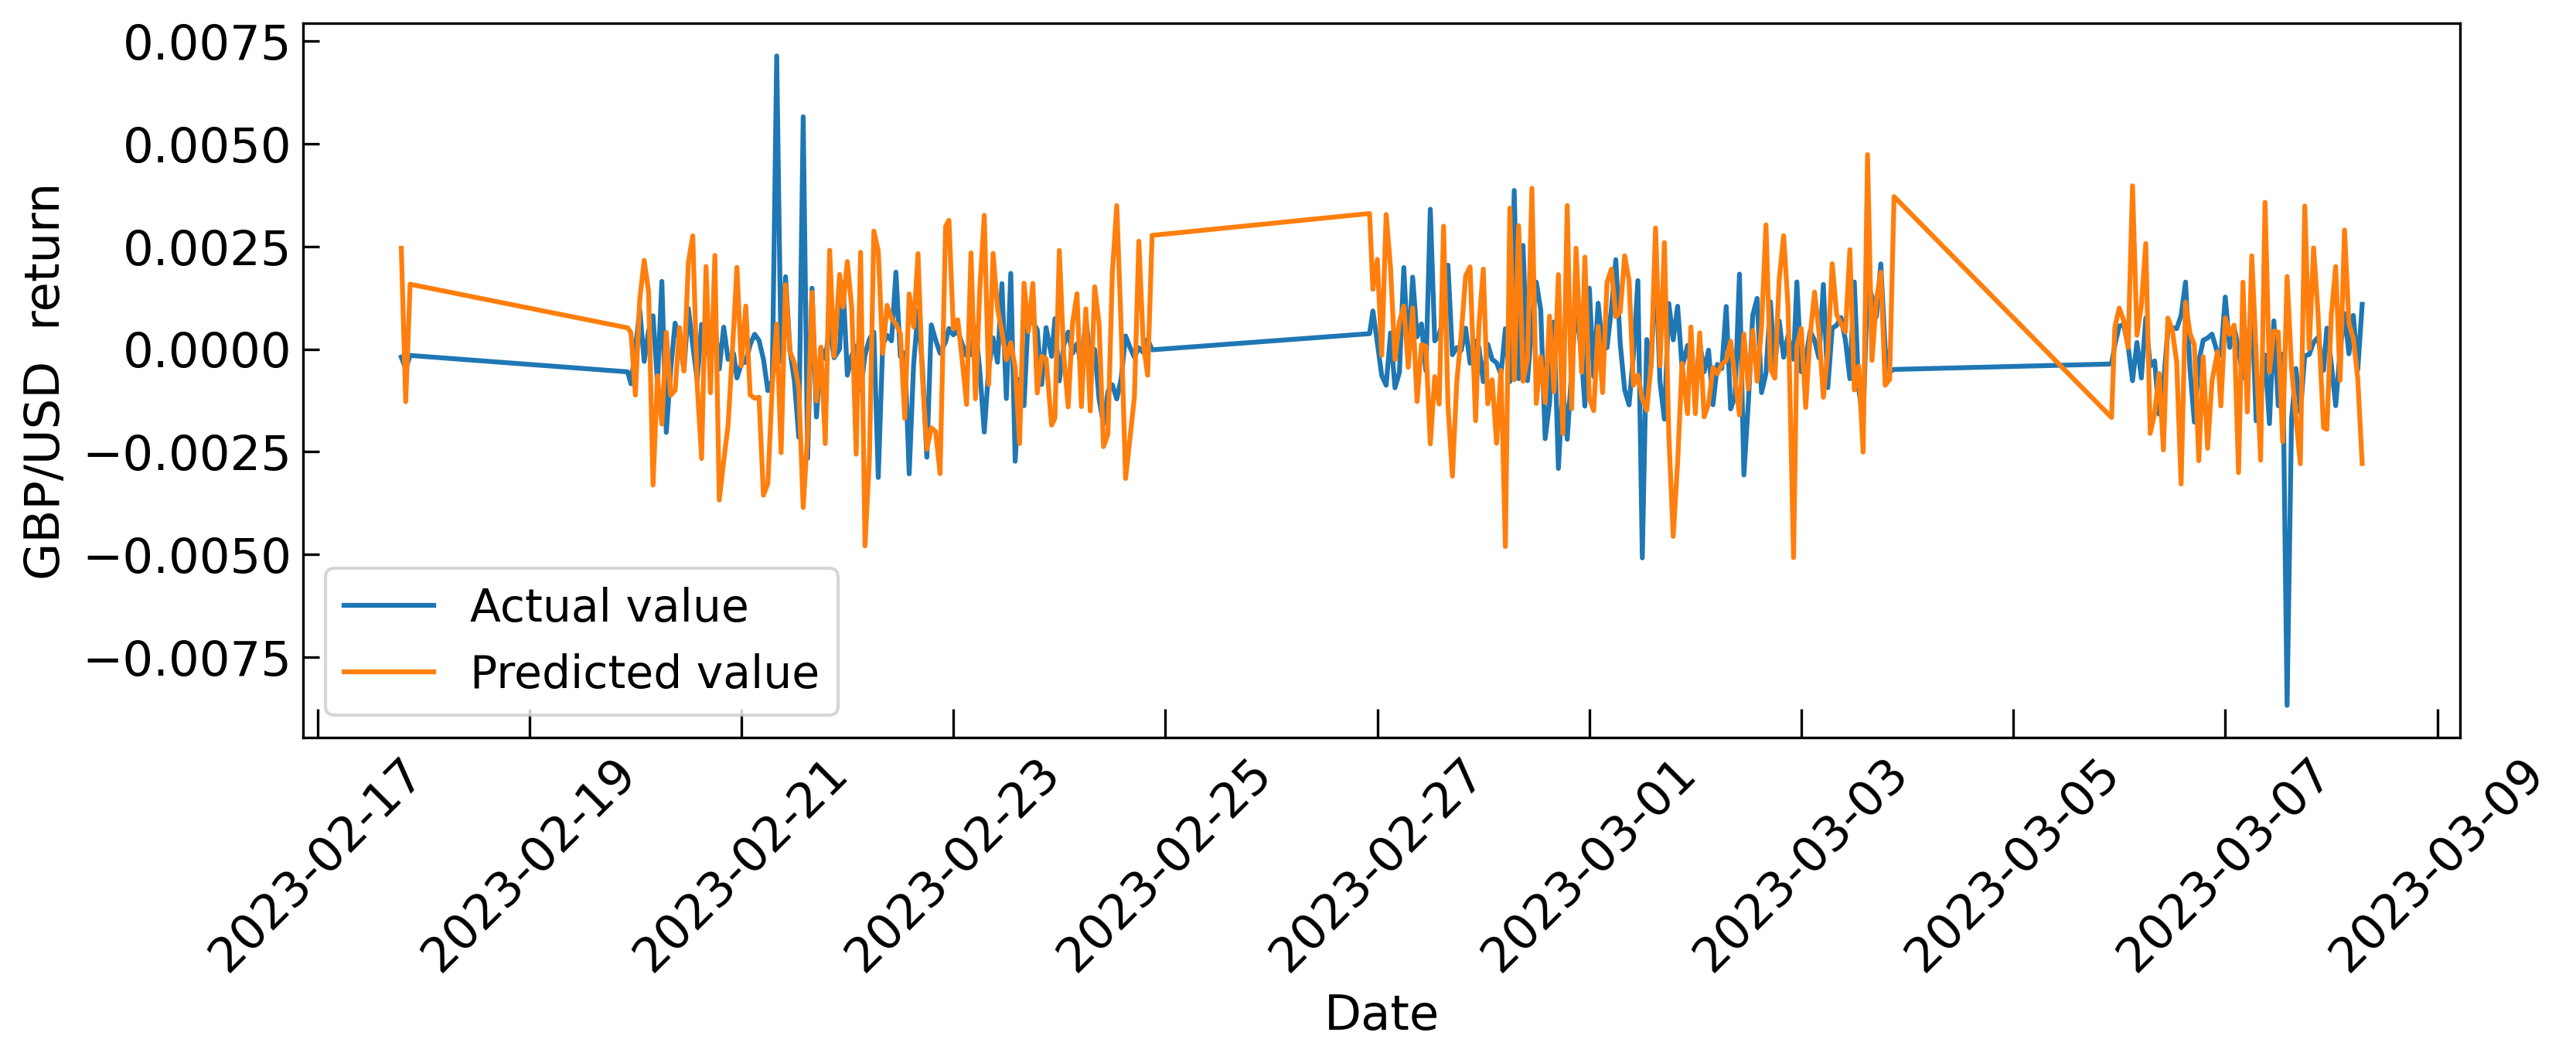

In [177]:
plt.figure(figsize=(12, 4))
plt.plot(results_df.index, results_df['actual'], label = 'Actual value')
plt.plot(results_df.index, results_df['mean'], label = 'Predicted value')
plt.xlabel('Date')
plt.ylabel('GBP/USD  return')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Algostrategy backtesting

In [178]:
results_df['Close'] = df['close']

In [179]:
    signals = results_df['mean'].apply(lambda x: "BUY" if x > 0 else 'SELL')
    df_performance = pd.DataFrame()
    df_performance['signal'] = signals
    df_performance.index = signals.index
    df_performance['Close'] = df["close"]
    df_performance['spread'] = df['spread_close']

In [180]:
def run_backtest(df):
    initial_cash = 10000
    cash = initial_cash
    shares = 0
    portfolio_value = initial_cash
    position = None  # 'BUY' for long, 'SELL' for short, None for no position
    entry_price = 0

    # Add columns for portfolio value and cumulative return to the dataframe
    df['Portfolio Value'] = initial_cash
    df['Cumulative Return'] = 0.0

    # Backtesting algorithm
    for i in range(len(df)):
        current_signal = df.iloc[i]['signal']
        spread = df.iloc[i]['spread']
        half_spread = spread / 2

        # Adjusted buy and sell prices considering the spread
        adjusted_buy_price = df.iloc[i]['Close'] + half_spread
        adjusted_sell_price = df.iloc[i]['Close'] - half_spread

        # If it's the first iteration or if there is a signal change, we need to act
        if i == 0 or current_signal != df.iloc[i-1]['signal']:
            if position is not None:
                # Close the current position
                if position == 'BUY':
                    # Sell at the adjusted sell price
                    cash += shares * adjusted_sell_price
                elif position == 'SELL':
                    # Close the short at the adjusted buy price
                    cash += shares * (2 * entry_price - adjusted_buy_price)

            shares = 0  # Reset the shares after closing the position

            # Open new position based on the signal
            if current_signal == 'BUY':
                position = 'BUY'
                shares = cash // adjusted_buy_price
                cash -= shares * adjusted_buy_price
                entry_price = adjusted_buy_price
            elif current_signal == 'SELL':
                position = 'SELL'
                shares = cash // adjusted_sell_price
                cash -= shares * adjusted_sell_price
                entry_price = adjusted_sell_price

        # If the signal is the same as the previous, we need to update the portfolio value
        if position == 'BUY':
            # Update portfolio value for a long position
            portfolio_value = cash + shares * df.iloc[i]['Close']
        elif position == 'SELL':
            # Update portfolio value for a short position
            portfolio_value = cash + shares * (2 * entry_price - df.iloc[i]['Close'])
        else:
            # Update portfolio value if there is no position
            portfolio_value = cash

        # Update the portfolio value and cumulative return for the current step
        df.at[df.index[i], 'Portfolio Value'] = portfolio_value
        df.at[df.index[i], 'Cumulative Return'] = (portfolio_value - initial_cash) / initial_cash

    # Display the dataframe
    return df

    

In [181]:
perf = run_backtest(df_performance)

<function matplotlib.pyplot.show(close=None, block=None)>

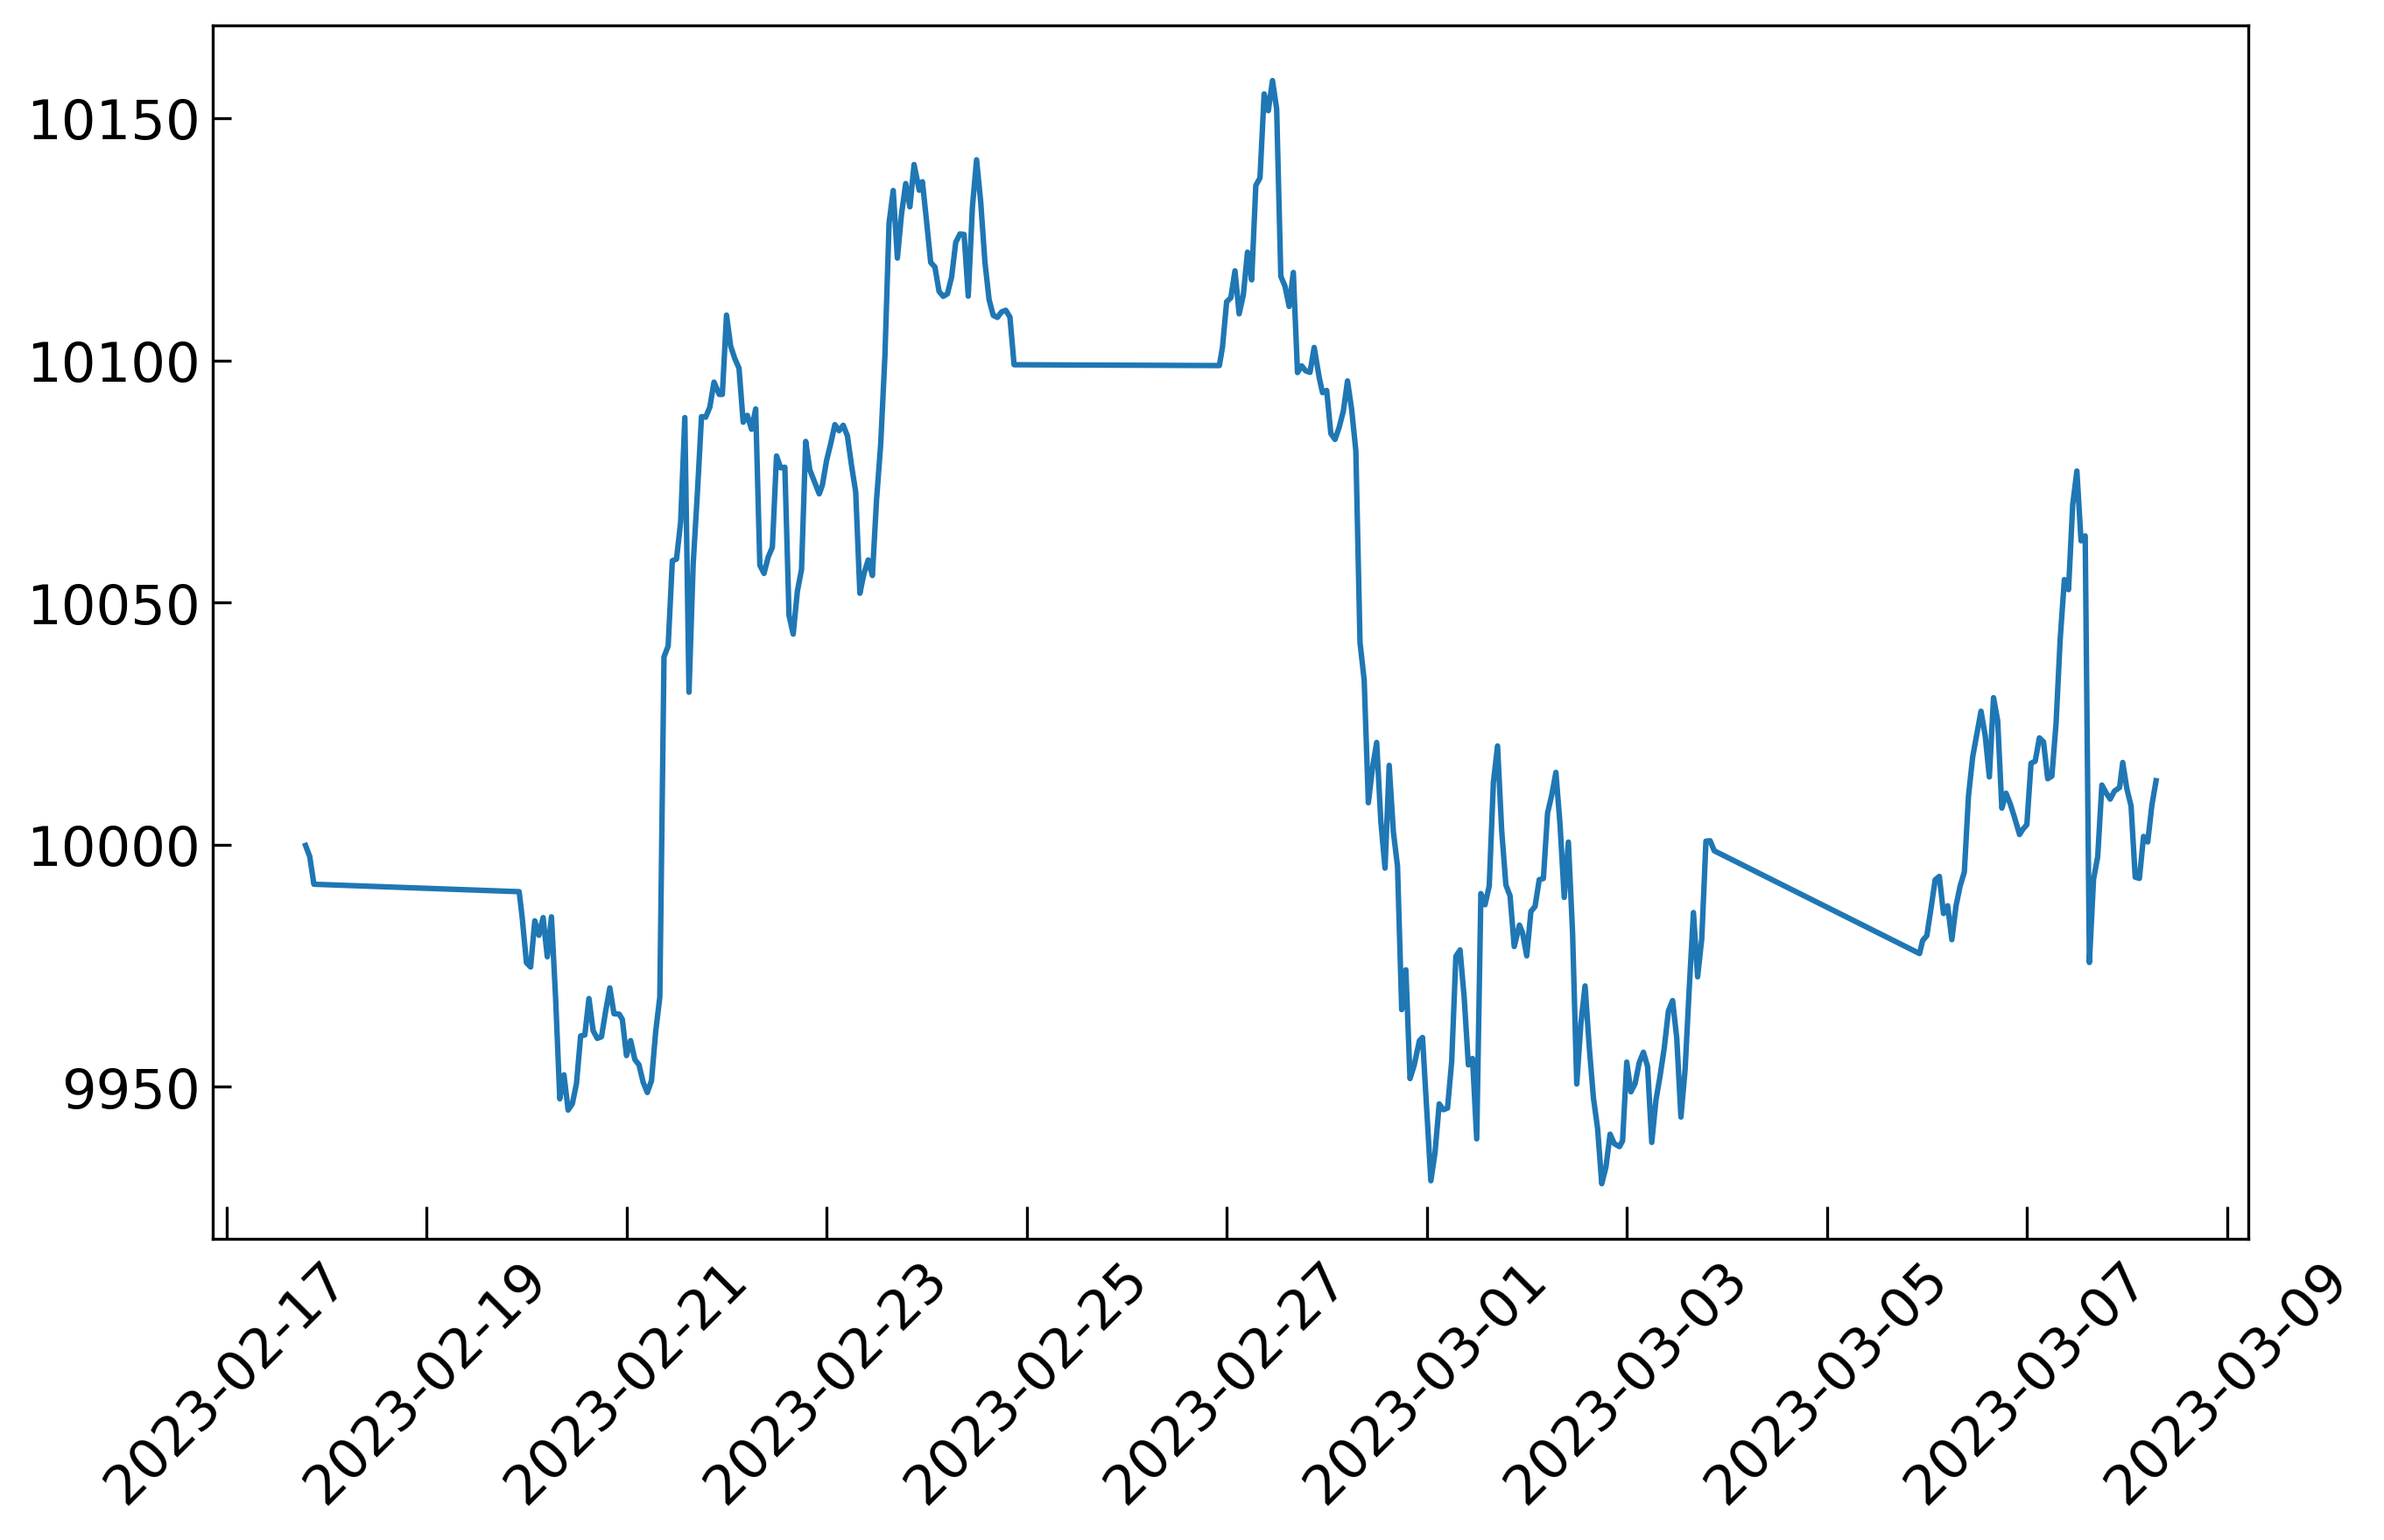

In [182]:
plt.plot(perf['Portfolio Value'])
plt.xticks(rotation=45)
plt.show

## Hyperparameter optimization. To be continued...

In [ ]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.callbacks import VerboseCallback

In [ ]:
space = [
    Integer(450, 4000, name='D'),
    Integer(50, 200, name='roll_size'),
    Integer(1, 50, name='n_bags'),
    Integer(50, 200, name='feature_num'),
    # Add more hyperparameters here if needed
]

In [ ]:
@use_named_args(space)
def model_evaluation(D, roll_size, n_bags, feature_num):
    
    sigma = 1
    ff = 1
    l = 0
    # Initialize the neccesary lists
    models = []
    bags = []

    # Select the most recent data from the available dataframe
    df_model = df_past[-(roll_size+1):] # size is roll_size + 1, because we need 1 more point to make prediction
                                        # for that point we don't know the target variable yet

    # calculate targets and scale the data
    Y, X, scaler_Y, scaler_X = prepare_data_new(df_model) 

    # perform RFF transformation
    lags = X.shape[0]
    rff = GaussianRFF(lags, D, sigma)
    X_trans = rff.transform(X.reshape(lags, roll_size+1)).T

    #Sampling features in each bag
    features_array = sample_features(D,n_bags,feature_num)

    for p in range(n_bags):
        bags.append(X_trans[:,features_array[p]])

    # Parallel execution of the first loop. Model initialization
    results = Parallel(n_jobs=-1)(delayed(process_initial_bag)(p, bags, Y, scaler_Y, ff, l, feature_num, roll_size) for p in tqdm(range(0, n_bags)))
    all_bags_preds = np.array([result[0] for result in results])
    models = [result[1] for result in results]

    #Add results in a results dataframe for comparison
    results_df['actual'].iloc[0] = df_future['close'][0]/df_past['close'][-1]-1 #actual target
    results_df['mean'].iloc[0] = np.mean(all_bags_preds)

    #Continue performing forecasts by updating QR_RLS model
    df_temp = df_model

    # we need the last row of RFF dataset to append it to train set on next iteration
    X_old = X_trans[-1,:].T  

    for i in tqdm(range(0, 300)):

        #Delete old data and append data, that just became available
        df_temp = df_temp.iloc[1:]
        df_temp = df_temp.append(df_future.iloc[i])

        Y, X, scaler_Y, scaler_X = prepare_data_new(df_temp)

        ## We need to perform RFF expansion on the new observation row. For which we don't have target
        ## And which will be used for forecasting
        X_new = rff.transform(X[:, -1:].reshape(lags, 1))

        # Parallel execution of the second loop
        all_bags_preds = Parallel(n_jobs=-1)(delayed(process_updated_bag)(p, X_old, X_new, models, scaler_Y, Y, features_array, feature_num) for p in range(0, n_bags))

        #new obeservation will be appended to train set in the next iteration
        X_old = X_new 

        # record results
        results_df['actual'].iloc[i+1] = df_future['close'][i+1]/df_temp['close'][-1]-1 #actual target
        results_df['mean'].iloc[i+1] = np.mean(all_bags_preds)

    # Calculate the performance metric
    results_df.dropna(inplace = True)
    same_sign_count = ((results_df['mean'] > 0) & (results_df['actual'] > 0)).sum() + ((results_df['mean'] < 0) & (results_df['actual'] < 0)).sum()
    total_rows = len(results_df)
    percentage_different_sign = (1-(same_sign_count / total_rows)) * 100

    return percentage_different_sign

In [ ]:
class CustomCallback(VerboseCallback):
    def __init__(self, n_total_calls):
        super().__init__(n_total_calls)

    def __call__(self, res):
        super().__call__(res)
        # Print the current iteration number and best score
        print(f"Iteration {len(res.x_iters)} completed.")
        print(f"Current best score: {res.fun}")

        # Print the best parameters found so far
        print("Current best parameters:", res.x)